# Tarea 1 Minería de Texto

Estudiante: Sofía Vits

Profesora: María Paz Raveau

Fecha entrega: 20 julio 2025

## Introducción

Una agencia gubernamental me contactó para saber qué dijeron los participantes de los cabildos provinciales de 2016. Como química, les expliqué que mi especialidad me permitía interpretar de mejor manera el concepto de "Respeto a la naturaleza/medio ambiente", quedando de acuerdo con la agencia que mi análisis se enfocaría en estudiar dicho concepto.


Carga de librerías

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import math
import nltk
import string
from wordcloud import WordCloud
remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
from itertools import compress
from nltk import word_tokenize
import networkx as nx

In [ ]:
import stanza
stanza.download('es')
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


Otras librerías utilizadas en la tarea 1:

spacy: [Fuente](https://spacy.io/)

Descripción breve: spaCy es una librería de procesamiento de lenguaje natural, diseñada para su uso en producción (no está creada para propósitos de investigación), facilitando el procesamiento de grandes volúmenes de texto. En este trabajo se usará para filtrar sustantivos y adjetivos presentes en la columna 'fundamento'.

networkx: [Fuente](https://networkx.org/)

Descripción breve: NetworkX es una librería que permite crear, manipular, y estudiar la estructura, dinámica, y funciones de redes complejas.

### Carga y pre-procesamiento de los datos de los cabildos provinciales.

In [ ]:
cabildos = pd.read_excel('resultadocabildoprovincial.xlsx')

Primero se aplica un filtro para seleccionar la información relacionada con el concepto "Respeto a la naturaleza/medio ambiente."

In [ ]:
cabildos_naturaleza = cabildos[cabildos['concepto_nombre'] == "Respeto a la naturaleza/medio ambiente"]

In [ ]:
cabildos_naturaleza.shape

(465, 12)

Luego se filtran las filas que no contienen frases que contegan información útil para elaborar wordclouds y la red de bigramas.

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza[cabildos_naturaleza['fundamento']!='sin fundamento']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(455, 12)

In [ ]:
cabildos_naturaleza_fundamentos.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
14,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Sin fundamento
112,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",4,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,los integrantes acuerdan que es fundamental qu...
154,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Medio ambiente grato\nAire puro/agua pura\nRes...
226,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",7,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,no tiene fundamentos
298,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",9,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,P,idem


In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='idem']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(454, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Sin Fundamento']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(448, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('Sin fundamentacion')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(445, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('SIN FUNDAMENTO')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(429, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Acuerdo']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(428, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('no fundamentan')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(427, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Validado por la comisión']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(426, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='no hay comentarios']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(425, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='No Hay Fundamento']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(423, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='No se prioriza dentro del grupo']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(422, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('IN FUNDAMENTO')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(421, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('0')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(412, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='xxx']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Iden a Valores y principios (2)']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('Mal redactado')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(409, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('NO HAY FUNDAMENTO')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('sin argumento')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='No hay']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(402, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('sin respuesta')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('(campo vacío)')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('NO HAY')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Unanimidad']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='se ratifica documento']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('Sin Fundamentación')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Votación unánime']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Sin fundamentación.']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Se entiende por si misma.']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('8 acuerdos. 3 acuerdos parciales')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Se fundamenta por el enunciado.']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='No hubo discusión, todos de acuerdo.']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('no fundamentaron')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('SIN DESCRIPCION')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('no realizaron fundamentación')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='18 votos']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='APROBADO DE MANERA UNANIME']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('Iden a Valores y principios')]

In [ ]:
cabildos_naturaleza_fundamentos.shape

(381, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos.query('fundamento != "."')

In [ ]:
cabildos_naturaleza_fundamentos.shape

(356, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos.query('fundamento != "-"')

In [ ]:
cabildos_naturaleza_fundamentos.shape

(351, 12)

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos.query('fundamento != "absolutamente de acuerdo"')

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos.query('fundamento != "O"')

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('in fundamento')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('fundamento')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='acuerdo']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Acuerdo.']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[~cabildos_naturaleza['fundamento'].str.contains('Fundamento')]

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='22 / 22\n3 Personas ausentes.']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='Sin descripción.-']

In [ ]:
cabildos_naturaleza_fundamentos = cabildos_naturaleza_fundamentos[cabildos_naturaleza['fundamento']!='No fundamentan']

In [ ]:
cabildos_naturaleza_fundamentos.shape

(285, 12)

In [ ]:
cabildos_naturaleza_fundamentos

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(column, errors="raise")


,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
112,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",4,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,los integrantes acuerdan que es fundamental qu...
154,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Medio ambiente grato\nAire puro/agua pura\nRes...
337,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",10,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,proteccion al territorio no a la depreciacion ...
387,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",11,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,debemos conservar y proteger el medio ambiente...
441,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",12,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,"en defensa y proteccion, conservacion, recuper..."
579,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",16,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,P,El derecho debe tener la soberanía sobre los r...
718,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",1,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Proteger la flora y fauna existente en el terr...
770,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",2,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,"Una vez mas, las decisiones que impacten a un ..."
814,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",3,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Enfocar al respeto del ecosistema . Que exista...
884,Tarapacá,Iquique,Iquique,106,Colegio Inglés,"Patricio Lynch 1580, Iquique",1,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Todos tenemos el derecho de vivir en un ambien...


Después de eliminar las filas que contenían frases que se consideraron que no aportan al análisis requerido, se almacenan los resultados de este proceso de limpieza.

In [ ]:
cabildos_naturaleza_fundamentos.to_excel('cabildos_naturaleza.xlsx', index=False)

El siguiente paso es lemmatizar las frases contenidas en la columna 'fundamento' del dataset de cabildos provinciales.

In [ ]:
cabildos_naturaleza_fundamentos = pd.read_excel('cabildos_naturaleza.xlsx') # Carga el dataset preprocesado

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Se define la función para lemmatizar las frases.

In [ ]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([x.lemma for x in doc.sentences[0].words])

In [ ]:
len(set(word_tokenize(' '.join(cabildos_naturaleza_fundamentos.fundamento.to_list()))))

1242

In [ ]:
cabildos_naturaleza_fundamentos['lemma'] = [lemmatizer(x) for x in cabildos_naturaleza_fundamentos['fundamento']]

In [ ]:
len(set(word_tokenize(' '.join(cabildos_naturaleza_fundamentos.lemma.to_list()))))

664

In [ ]:
cabildos_naturaleza_fundamentos['lemma'] = cabildos_naturaleza_fundamentos['lemma'].str.lower()
len(set(word_tokenize(' '.join(cabildos_naturaleza_fundamentos.lemma.to_list()))))

650

In [ ]:
cabildos_naturaleza_fundamentos['lemma'] = cabildos_naturaleza_fundamentos['lemma'].str.translate(str.maketrans(' ', ' ', string.punctuation))
cabildos_naturaleza_fundamentos['lemma'] = cabildos_naturaleza_fundamentos['lemma'].str.translate(str.maketrans(' ', ' ', string.digits))
len(set(word_tokenize(' '.join(cabildos_naturaleza_fundamentos.lemma.to_list()))))

631

In [ ]:
cabildos_naturaleza_fundamentos['lemma'] = cabildos_naturaleza_fundamentos['lemma'].str.strip()
cabildos_naturaleza_fundamentos['lemma'] = cabildos_naturaleza_fundamentos['lemma'].str.replace('\n',' ')
len(set(word_tokenize(' '.join(cabildos_naturaleza_fundamentos.lemma.to_list()))))

631

In [ ]:
cabildos_naturaleza_lemma = cabildos_naturaleza_fundamentos[[len(x.split( )) >2  for x in cabildos_naturaleza_fundamentos.lemma]]
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma.reset_index(drop=True)
len(set(word_tokenize(' '.join(cabildos_naturaleza_lemma.lemma.to_list()))))

628

Se guardan en un archivo los resultados de la lemmatización.

In [ ]:
cabildos_naturaleza_lemma.to_excel('cabildos_naturaleza_lemma.xlsx', index=False)

In [ ]:
cabildos_naturaleza_lemma = pd.read_excel('cabildos_naturaleza_lemma.xlsx') # carga el dataset lemmatizado

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

En este paso se eliminan las stopwords presentes en el dataset.

In [ ]:
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['deber', 'concepto', 'través']
esp_stop.remove('estado')
esp_stop.remove('estados')

Se importa la librería spaCy para filtrar los sustantivos y adjetivos de las frases a analizar.

In [ ]:
import spacy
# Cargar el modelo de español
nlp = spacy.load('es_core_news_sm')


In [ ]:
# Función para filtrar sustantivos y adjetivos usando spaCy
def filtrar_sustantivos_adjetivos(texto):
    # La variable 'texto' es una cadena de texto, así que la procesamos directamente.
    doc = nlp(texto)

    # Nos quedamos solo con las palabras que son sustantivos o adjetivos
    palabras_filtradas = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]

    # Devolvemos el resultado como una sola cadena de texto
    return ' '.join(palabras_filtradas)


In [ ]:
# 1. Filtramos los textos iniciales que tengan más de 2 palabras
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma[cabildos_naturaleza_lemma['lemma'].apply(len) > 2].copy()

# 2. Aplicamos la nueva función a la columna 'lemma'
cabildos_naturaleza_lemma['lemma'] = cabildos_naturaleza_lemma['lemma'].apply(filtrar_sustantivos_adjetivos)

# 3. Limpiamos las filas que quedaron vacías y reiniciamos el índice
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma[cabildos_naturaleza_lemma['lemma'] != '']
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma.reset_index(drop=True)

# Muestra el resultado
print(cabildos_naturaleza_lemma.head())

        region_nombre provincia_nombre comuna_nombre  cabildo_id  \
0  Arica y Parinacota            Arica         Arica          81   
1  Arica y Parinacota            Arica         Arica          81   
2  Arica y Parinacota            Arica         Arica          81   
3  Arica y Parinacota            Arica         Arica          81   
4  Arica y Parinacota            Arica         Arica          81   

       cabildo_nombre        cabildo_direccion  num_mesa  \
0  Colegio San Marcos  Santa María 2140, Arica         4   
1  Colegio San Marcos  Santa María 2140, Arica         5   
2  Colegio San Marcos  Santa María 2140, Arica        10   
3  Colegio San Marcos  Santa María 2140, Arica        11   
4  Colegio San Marcos  Santa María 2140, Arica        12   

                                      pregunta_glosa  \
0  ¿Cuáles son los derechos, que la Constitución ...   
1  ¿Cuáles son los derechos, que la Constitución ...   
2  ¿Cuáles son los derechos, que la Constitución ...   
3  ¿Cu

In [ ]:
cabildos_bigramas = cabildos_naturaleza_lemma.copy() # copia el dataframe para crear bigramas posteriormente

En esta parte se filtra para dejar sólo los sustantivos presentes en la columna 'fundamento'.

In [ ]:
# Función para filtrar sustantivos usando spaCy
def filtrar_sustantivos(texto):
    # La variable 'texto' es una cadena de texto, así que la procesamos directamente.
    doc = nlp(texto)

    # Nos quedamos solo con las palabras que son sustantivos o adjetivos
    palabras_filtradas = [token.text for token in doc if token.pos_ in ['NOUN']]

    # Devolvemos el resultado como una sola cadena de texto
    return ' '.join(palabras_filtradas)

In [ ]:
# 1. Filtramos los textos iniciales que tengan más de 2 palabras
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma[cabildos_naturaleza_lemma['lemma'].apply(len) > 2].copy()

# 2. Aplicamos la nueva función a la columna 'lemma'
cabildos_naturaleza_lemma['lemma'] = cabildos_naturaleza_lemma['lemma'].apply(filtrar_sustantivos)

# 3. Limpiamos las filas que quedaron vacías y reiniciamos el índice
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma[cabildos_naturaleza_lemma['lemma'] != '']
cabildos_naturaleza_lemma = cabildos_naturaleza_lemma.reset_index(drop=True)

# Muestra el resultado
print(cabildos_naturaleza_lemma.head())

        region_nombre provincia_nombre comuna_nombre  cabildo_id  \
0  Arica y Parinacota            Arica         Arica          81   
1  Arica y Parinacota            Arica         Arica          81   
2  Arica y Parinacota            Arica         Arica          81   
3  Arica y Parinacota            Arica         Arica          81   
4  Arica y Parinacota            Arica         Arica          81   

       cabildo_nombre        cabildo_direccion  num_mesa  \
0  Colegio San Marcos  Santa María 2140, Arica         4   
1  Colegio San Marcos  Santa María 2140, Arica         5   
2  Colegio San Marcos  Santa María 2140, Arica        10   
3  Colegio San Marcos  Santa María 2140, Arica        11   
4  Colegio San Marcos  Santa María 2140, Arica        12   

                                      pregunta_glosa  \
0  ¿Cuáles son los derechos, que la Constitución ...   
1  ¿Cuáles son los derechos, que la Constitución ...   
2  ¿Cuáles son los derechos, que la Constitución ...   
3  ¿Cu

In [ ]:
cabildos_sustantivos = cabildos_naturaleza_lemma.copy() # copia el dataset

In [ ]:
cabildos_sustantivos

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento,lemma
0,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",4,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,los integrantes acuerdan que es fundamental qu...,integrante
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Medio ambiente grato\nAire puro/agua pura\nRes...,medio ambiente grato aire resguardo generación
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",10,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,proteccion al territorio no a la depreciacion ...,protección territorio recurso
3,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",11,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,debemos conservar y proteger el medio ambiente...,biodiversidad
4,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",12,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,"en defensa y proteccion, conservacion, recuper...",defensa protección conservación
5,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",16,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,P,El derecho debe tener la soberanía sobre los r...,derecho recurso
6,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",1,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Proteger la flora y fauna existente en el terr...,fauna territorio
7,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",2,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,"Una vez mas, las decisiones que impacten a un ...",vez decisión participación territorio cuestión
8,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",3,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Enfocar al respeto del ecosistema . Que exista...,respeto ecosistema
9,Tarapacá,Iquique,Iquique,106,Colegio Inglés,"Patricio Lynch 1580, Iquique",1,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Todos tenemos el derecho de vivir en un ambien...,derecho ambiente estado


In [ ]:
vocab = set(word_tokenize(' '.join(cabildos_sustantivos.lemma.to_list())))

In [ ]:
vocab = [x for x in vocab if x not in esp_stop]

In [ ]:
len(vocab)

177

In [ ]:
cabildos_sustantivos.sample(10).lemma.tolist()

['derecho ambiente',
 'medio ambiente desarrollo tiempo respeto calidad sensibilidad',
 'vida ambiente contaminación respeto naturaleza',
 'valor',
 'existencia',
 'ciudadano ambiente',
 'naturaleza medio ambiente conservación medio ambiente',
 'protección naturaleza ambiente',
 'organismo sustentabilidad',
 'desarrollo explotación recurso existencia preservación generación']

### Bag of Words

Se crea una matriz del tipo Document-Term Matrix (DTM) para determinar frecuencia de los sustantivos y bigramas sustantivo-adjetivo relacionados con el concepto "Respeto a la naturaleza/medio ambiente". Se eligió esta matriz debido a que no penaliza las palabras más comunes.

In [ ]:
cabildos_sustantivos.shape

(259, 13)

Creación de la matriz DTM

In [ ]:
%%time

from collections import Counter

dtm=pd.DataFrame()
for ix in range(100):
    frase = cabildos_sustantivos.lemma[ix]
    tokens = word_tokenize(frase)
    tcounts1 = Counter(x for x in tokens if x in vocab)
    df_counts = pd.DataFrame.from_dict([tcounts1]).reset_index()
    dtm = pd.concat([dtm,df_counts], axis=0, ignore_index=True)
dtm.drop(['index'],axis=1,inplace=True)

CPU times: user 416 ms, sys: 5.88 ms, total: 422 ms
Wall time: 423 ms


In [ ]:
dtm.head()

,integrante,medio,ambiente,grato,aire,resguardo,generación,protección,territorio,recurso,biodiversidad,defensa,conservación,derecho,fauna,vez,decisión,participación,cuestión,respeto,ecosistema,estado,sociedad,equilibrio,sustentabilidad,reevaluación,desarrollo,explotación,existencia,preservación,tierra,progreso,naturaleza,aplicaciones,acuerdo,tema,condición,vida,internación,región,daño,plazo,calidad,espacio,país,organismo,riqueza,transgresor,votación,encuentro,acceso,importancia,salud,contaminación,responsabilidad,energia,costo,fiscalización,empresa,ganancia,elemento,agua,ciudadano,base,especie,interés,mantención,contexto,entorno,objeción,persona,opinión,recuperación,parte,transformación,aprovechamiento,ley,favor,forma,ciclo,objeto,economía,modelo,mundo,valor,educación,restricción,actividad,normativa,regulación,tendencia,privatización,categoría,oportunidad,empleo
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dtm = dtm.fillna(0)

In [ ]:
dtm.head()

,integrante,medio,ambiente,grato,aire,resguardo,generación,protección,territorio,recurso,biodiversidad,defensa,conservación,derecho,fauna,vez,decisión,participación,cuestión,respeto,ecosistema,estado,sociedad,equilibrio,sustentabilidad,reevaluación,desarrollo,explotación,existencia,preservación,tierra,progreso,naturaleza,aplicaciones,acuerdo,tema,condición,vida,internación,región,daño,plazo,calidad,espacio,país,organismo,riqueza,transgresor,votación,encuentro,acceso,importancia,salud,contaminación,responsabilidad,energia,costo,fiscalización,empresa,ganancia,elemento,agua,ciudadano,base,especie,interés,mantención,contexto,entorno,objeción,persona,opinión,recuperación,parte,transformación,aprovechamiento,ley,favor,forma,ciclo,objeto,economía,modelo,mundo,valor,educación,restricción,actividad,normativa,regulación,tendencia,privatización,categoría,oportunidad,empleo
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dtm.shape

(100, 95)

In [ ]:
toks = []
for ix in range(cabildos_sustantivos.shape[0]):
    frase = cabildos_sustantivos.lemma[ix]
    tokens = word_tokenize(frase)
    tokens = [x for x in tokens if x in vocab]
    toks.extend(tokens)

In [ ]:
len(toks)

587

In [ ]:
df_tokens = pd.DataFrame(list(zip(toks)), columns =['token'])

En este punto se filtran los sustantivos que no aportan información.

In [ ]:
df_tokens = df_tokens[df_tokens['token'] != 'parte']

In [ ]:
df_tokens = df_tokens[df_tokens['token'] != 'acuerdo']

In [ ]:
df_tokens = df_tokens[df_tokens['token'] != 'valor']

In [ ]:
df_tokens = df_tokens[df_tokens['token'] != 'acceso']

In [ ]:
tokens_count = df_tokens['token'].value_counts().rename_axis('token').reset_index(name='counts')
tokens_count = tokens_count[tokens_count.counts>3]

In [ ]:
tokens_count.head()

,token,counts
0,naturaleza,66
1,derecho,41
2,recurso,39
3,ambiente,38
4,desarrollo,29


In [ ]:
tokens_count = tokens_count[~tokens_count.token.isin(esp_stop)]

Se crea el wordcloud de sustantivos.

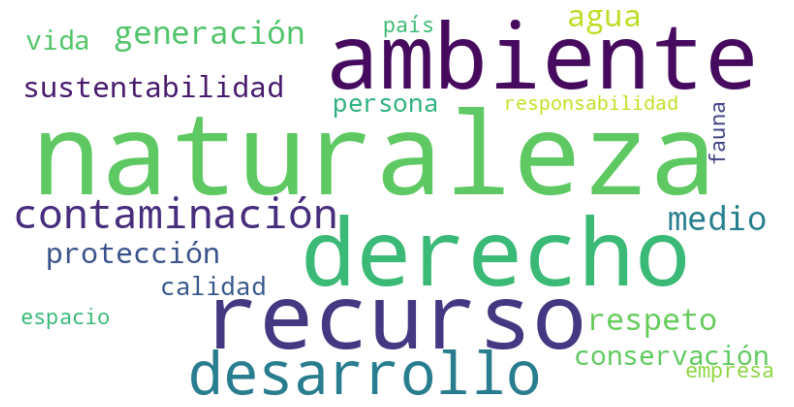

In [ ]:
data = dict(zip(tokens_count['token'].tolist(), tokens_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=150).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

En la nube de sustantivos se observa que las palabras más frecuentes para explicar el concepto son naturaleza, derecho, recurso, ambiente y desarrollo.
Las palabras que aparecen en la nube concuerdan con lo esperable para fundamentar el concepto de "respeto a la naturaleza/medio ambiente" y explican las preocupaciones de los participantes de los cabildos proviciales.

A pesar de ser términos mencionados en el concepto, no se eliminaron las palabras naturaleza y medio debido a que naturaleza no es un sinónimo de medio ambiente.

La RAE define naturaleza como "Medio físico en el que coexisten los seres vivos y los inertes al margen de la vida urbana.". En cambio define medio ambiente como "conjunto de circunstancias exteriores a un ser vivo".

Además, la ley 19.300 sobre Bases Generales del Medio Ambiente define en su artículo 2 al medioambiente como "el sistema global constituido por elementos naturales y artificiales de naturaleza física, química o biológica, socioculturales y sus interacciones, en permanente modificación por la acción humana o natural y que rige y condiciona la existencia y desarrollo de la vida en sus múltiples manifestaciones".

Tomando en cuenta estas definiciones, consideraremos que medio ambiente es el conjunto general al cual pertenecería la naturaleza. Por lo tanto, son conceptos distintos.

Se procede a determinar los bigramas sustantivo-adjetivo.

In [ ]:
cabildos_bigramas.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento,lemma
0,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",4,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,los integrantes acuerdan que es fundamental qu...,integrante fundamental
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,Medio ambiente grato\nAire puro/agua pura\nRes...,medio ambiente grato aire puroagua puro resgua...
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",10,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,proteccion al territorio no a la depreciacion ...,protección territorio depreciación recurso nat...
3,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",11,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,debemos conservar y proteger el medio ambiente...,medio biodiversidad
4,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",12,"¿Cuáles son los derechos, que la Constitución ...",Respeto a la naturaleza/medio ambiente,NaN,A,"en defensa y proteccion, conservacion, recuper...",defensa protección conservación recuperación


In [ ]:
from nltk import bigrams
bigrams(toks)

<generator object bigrams at 0x7a644bb73ca0>

In [ ]:
[' '.join(x) for x in list(bigrams(toks))]

['integrante medio',
 'medio ambiente',
 'ambiente grato',
 'grato aire',
 'aire resguardo',
 'resguardo generación',
 'generación protección',
 'protección territorio',
 'territorio recurso',
 'recurso biodiversidad',
 'biodiversidad defensa',
 'defensa protección',
 'protección conservación',
 'conservación derecho',
 'derecho recurso',
 'recurso fauna',
 'fauna territorio',
 'territorio vez',
 'vez decisión',
 'decisión participación',
 'participación territorio',
 'territorio cuestión',
 'cuestión respeto',
 'respeto ecosistema',
 'ecosistema derecho',
 'derecho ambiente',
 'ambiente estado',
 'estado derecho',
 'derecho sociedad',
 'sociedad equilibrio',
 'equilibrio sustentabilidad',
 'sustentabilidad reevaluación',
 'reevaluación desarrollo',
 'desarrollo explotación',
 'explotación recurso',
 'recurso existencia',
 'existencia preservación',
 'preservación generación',
 'generación tierra',
 'tierra recurso',
 'recurso desarrollo',
 'desarrollo progreso',
 'progreso recurso',
 

In [ ]:
ngramos = []
for ix in range(cabildos_bigramas.shape[0]):
    mytext = cabildos_bigramas.lemma[ix]
    tokens = word_tokenize(mytext)
    tokens = [x for x in tokens if x not in esp_stop]
    if len(tokens)>1:
        bi_tokens = [' '.join(x) for x in list(bigrams(tokens))]
    ngramos.extend(bi_tokens)

ngram = pd.DataFrame(list(zip(ngramos)), columns =['ngram'])


In [ ]:
ngram

,ngram
0,integrante fundamental
1,medio ambiente
2,ambiente grato
3,grato aire
4,aire puroagua
...,...
1107,forma naturaleza
1108,naturaleza forma
1109,forma posible
1110,derecho ambiente


Se eliminan los bigramas que no son del tipo sustantivo + adjetivo, que no aportan información suficiente al wordcloud, que están relacionados con otros temas, o que presentan errores de escritura.

In [ ]:
ngram = ngram[ngram['ngram']!='grato aire']

In [ ]:
ngram = ngram[ngram['ngram']!='existente territorio']

In [ ]:
ngram = ngram[ngram['ngram']!='territorio ecosistema']

In [ ]:
ngram = ngram[ngram['ngram']!='vez decisión']

In [ ]:
ngram = ngram[ngram['ngram']!='puroagua puro']

In [ ]:
ngram = ngram[ngram['ngram']!='puro resguardo']

In [ ]:
ngram = ngram[ngram['ngram']!='resguardo generación']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto ecosistema']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano territorio']

In [ ]:
ngram = ngram[ngram['ngram']!='flora fauna']

In [ ]:
ngram = ngram[ngram['ngram']!='decisión territorio']

In [ ]:
ngram = ngram[ngram['ngram']!='sano protegido']

In [ ]:
ngram = ngram[ngram['ngram']!='protegido estado']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación recuperación']

In [ ]:
ngram = ngram[ngram['ngram']!='forma naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza forma']

In [ ]:
ngram = ngram[ngram['ngram']!='protección territorio']

In [ ]:
ngram = ngram[ngram['ngram']!='libre contaminación']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho medio']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza medio']

In [ ]:
ngram = ngram[ngram['ngram']!='estado ciudadano']

In [ ]:
ngram = ngram[ngram['ngram']!='natural sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='estado agua']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='sano sustentable']

In [ ]:
ngram = ngram[ngram['ngram']!='chileno derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='numero chileno']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho obligación']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable sostenible']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentabilidad derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza futuro']

In [ ]:
ngram = ngram[ngram['ngram']!='futuro generación']

In [ ]:
ngram = ngram[ngram['ngram']!='naturalezamedio ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza sujeto']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='persona espacio']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='futuras generación']

In [ ]:
ngram = ngram[ngram['ngram']!='agua luz']

In [ ]:
ngram = ngram[ngram['ngram']!='medio salud']

In [ ]:
ngram = ngram[ngram['ngram']!='hijos nietos']

In [ ]:
ngram = ngram[ngram['ngram']!='nietos futuras']

In [ ]:
ngram = ngram[ngram['ngram']!='efecto medio']

In [ ]:
ngram = ngram[ngram['ngram']!='integral ser']

In [ ]:
ngram = ngram[ngram['ngram']!='humano medio']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho flora']

In [ ]:
ngram = ngram[ngram['ngram']!='fauna recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso país']

In [ ]:
ngram = ngram[ngram['ngram']!='saludable libre']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='ligado vida']

In [ ]:
ngram = ngram[ngram['ngram']!='énfasis agua']

In [ ]:
ngram = ngram[ngram['ngram']!='limpio sano']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente fiscalización']

In [ ]:
ngram = ngram[ngram['ngram']!='armonia medio']

In [ ]:
ngram = ngram[ngram['ngram']!='relevante efecto']

In [ ]:
ngram = ngram[ngram['ngram']!='fiscalización equilibrio']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente hijos']

In [ ]:
ngram = ngram[ngram['ngram']!='básico desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente hijos']

In [ ]:
ngram = ngram[ngram['ngram']!='estado medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='natural propiedad']

In [ ]:
ngram = ngram[ngram['ngram']!='mejor nuevo']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental mundo']

In [ ]:
ngram = ngram[ngram['ngram']!='persona derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='importante cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='generación desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable transformación']

In [ ]:
ngram = ngram[ngram['ngram']!='total naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='parte derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental estado']

In [ ]:
ngram = ngram[ngram['ngram']!='entorno ambiental']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiental sujeto']

In [ ]:
ngram = ngram[ngram['ngram']!='constitucional sujeto']

In [ ]:
ngram = ngram[ngram['ngram']!='animal inmueble']

In [ ]:
ngram = ngram[ngram['ngram']!='natural recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='limpio sustentable']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho junto']

In [ ]:
ngram = ngram[ngram['ngram']!='junto sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho estado']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='contaminación derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='social cultural']

In [ ]:
ngram = ngram[ngram['ngram']!='través respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='defensa protección']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza protección']

In [ ]:
ngram = ngram[ngram['ngram']!='estado equilibrado']

In [ ]:
ngram = ngram[ngram['ngram']!='equilibrado saludable']

In [ ]:
ngram = ngram[ngram['ngram']!='derechjo recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso natutal']

In [ ]:
ngram = ngram[ngram['ngram']!='natutal transferibles']

In [ ]:
ngram = ngram[ngram['ngram']!='nustro generación']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso cultura']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='preservación respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='importante derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='obligacion derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano obligacion']

In [ ]:
ngram = ngram[ngram['ngram']!='valor estado']

In [ ]:
ngram = ngram[ngram['ngram']!='argumentado valor']

In [ ]:
ngram = ngram[ngram['ngram']!='humano esencial']

In [ ]:
ngram = ngram[ngram['ngram']!='saludable naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='centrales proyecto']

In [ ]:
ngram = ngram[ngram['ngram']!='contaminación ley']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza entorno']

In [ ]:
ngram = ngram[ngram['ngram']!='agua común']

In [ ]:
ngram = ngram[ngram['ngram']!='común fundamental']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza proveedor']

In [ ]:
ngram = ngram[ngram['ngram']!='riqueza manera']

In [ ]:
ngram = ngram[ngram['ngram']!='estado aire']

In [ ]:
ngram = ngram[ngram['ngram']!='proyecto ecosistema']

In [ ]:
ngram = ngram[ngram['ngram']!='paisaje diseóamo']

In [ ]:
ngram = ngram[ngram['ngram']!='diseóamo paisajes']

In [ ]:
ngram = ngram[ngram['ngram']!='paisajes relacionado']

In [ ]:
ngram = ngram[ngram['ngram']!='comunidad derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='animal marco']

In [ ]:
ngram = ngram[ngram['ngram']!='soberanía naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='medio respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='natural preservado']

In [ ]:
ngram = ngram[ngram['ngram']!='sostenible medio']

In [ ]:
ngram = ngram[ngram['ngram']!='vivienda espacio']

In [ ]:
ngram = ngram[ngram['ngram']!='economía cambio']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='restricción frente']

In [ ]:
ngram = ngram[ngram['ngram']!='necesario estado']

In [ ]:
ngram = ngram[ngram['ngram']!='sujeto dercho']

In [ ]:
ngram = ngram[ngram['ngram']!='sociedad recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='natural interés']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza ser']

In [ ]:
ngram = ngram[ngram['ngram']!='nacionalización privatización']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho objeto']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente educación']

In [ ]:
ngram = ngram[ngram['ngram']!='responsabilidad frente']

In [ ]:
ngram = ngram[ngram['ngram']!='productivo oportunidad']

In [ ]:
ngram = ngram[ngram['ngram']!='valor principio']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho valor']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho valor']

In [ ]:
ngram = ngram[ngram['ngram']!='argumento primero']

In [ ]:
ngram = ngram[ngram['ngram']!='valor derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='regulación control']

In [ ]:
ngram = ngram[ngram['ngram']!='productivo debido']

In [ ]:
ngram = ngram[ngram['ngram']!='persona ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='protección conservación']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho prolongación']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza animal']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental alimentación']

In [ ]:
ngram = ngram[ngram['ngram']!='políticas medio']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente libre']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente libre']

In [ ]:
ngram = ngram[ngram['ngram']!='protección medio']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho presentado']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho acceso']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho importante']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho persona']

In [ ]:
ngram = ngram[ngram['ngram']!='monsanto nacionalización']

In [ ]:
ngram = ngram[ngram['ngram']!='agua entidad']

In [ ]:
ngram = ngram[ngram['ngram']!='principal responsable']

In [ ]:
ngram = ngram[ngram['ngram']!='discusión unanimidad']

In [ ]:
ngram = ngram[ngram['ngram']!='entorno libre']

In [ ]:
ngram = ngram[ngram['ngram']!='largo plazo']

In [ ]:
ngram = ngram[ngram['ngram']!='gestión regulación']

In [ ]:
ngram = ngram[ngram['ngram']!='termoeléctricos centrales']

In [ ]:
ngram = ngram[ngram['ngram']!='regulación temático']

In [ ]:
ngram = ngram[ngram['ngram']!='tendencia responsable']

In [ ]:
ngram = ngram[ngram['ngram']!='sostenible derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='acceso flora']

In [ ]:
ngram = ngram[ngram['ngram']!='dañino hijo']

In [ ]:
ngram = ngram[ngram['ngram']!='lugar libre']

In [ ]:
ngram = ngram[ngram['ngram']!='humano nuevo']

In [ ]:
ngram = ngram[ngram['ngram']!='convivencia reparación']

In [ ]:
ngram = ngram[ngram['ngram']!='hijo nieto']

In [ ]:
ngram = ngram[ngram['ngram']!='propiedad derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='vida medio']

In [ ]:
ngram = ngram[ngram['ngram']!='estado cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente sanción']

In [ ]:
ngram = ngram[ngram['ngram']!='priorización encuentro']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza base']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto debido']

In [ ]:
ngram = ngram[ngram['ngram']!='medio naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='vital ybiológico']

In [ ]:
ngram = ngram[ngram['ngram']!='temático tendencia']

In [ ]:
ngram = ngram[ngram['ngram']!='sintiente objeción']

In [ ]:
ngram = ngram[ngram['ngram']!='parte sistema']

In [ ]:
ngram = ngram[ngram['ngram']!='educación respecto']

In [ ]:
ngram = ngram[ngram['ngram']!='respecto restricción']

In [ ]:
ngram = ngram[ngram['ngram']!='frente actividad']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado protección']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiental minima']

In [ ]:
ngram = ngram[ngram['ngram']!='contaminación protección']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='través estado']

In [ ]:
ngram = ngram[ngram['ngram']!='asegurarles futuras']

In [ ]:
ngram = ngram[ngram['ngram']!='basado costa']

In [ ]:
ngram = ngram[ngram['ngram']!='costa destrucción']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='medio ambiente'] #no aporta información porque es el nombre del concepto analizado

In [ ]:
ngram = ngram[ngram['ngram']!='derecho ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='sujeto derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='acceso naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='calidad vida']

In [ ]:
ngram = ngram[ngram['ngram']!='contaminación respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='habitante país']

In [ ]:
ngram = ngram[ngram['ngram']!='salud habitante']

In [ ]:
ngram = ngram[ngram['ngram']!='nuevo normativa']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto medio']

In [ ]:
ngram = ngram[ngram['ngram']!='principio derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='mejor calidad']

In [ ]:
ngram = ngram[ngram['ngram']!='propiedad estado']

In [ ]:
ngram = ngram[ngram['ngram']!='protección naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación medio']

In [ ]:
ngram = ngram[ngram['ngram']!='alto costo']

In [ ]:
ngram = ngram[ngram['ngram']!='estudios eficaz']

In [ ]:
ngram = ngram[ngram['ngram']!='importancia diferente']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho empresa']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente estado']

In [ ]:
ngram = ngram[ngram['ngram']!='existencia vida']

In [ ]:
ngram = ngram[ngram['ngram']!='reparación estado']

In [ ]:
ngram = ngram[ngram['ngram']!='estado ciudadanía']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='mayor regulación']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza educación']

In [ ]:
ngram = ngram[ngram['ngram']!='par respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='tradicional localidad']

In [ ]:
ngram = ngram[ngram['ngram']!='eficaz impacto']

In [ ]:
ngram = ngram[ngram['ngram']!='vida estado']

In [ ]:
ngram = ngram[ngram['ngram']!='nieto derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='adecuado persona']

In [ ]:
ngram = ngram[ngram['ngram']!='humano derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='común sociedad']

In [ ]:
ngram = ngram[ngram['ngram']!='país alto']

In [ ]:
ngram = ngram[ngram['ngram']!='estado factor']

In [ ]:
ngram = ngram[ngram['ngram']!='debido hábitat']

In [ ]:
ngram = ngram[ngram['ngram']!='fuente empresa']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho sujeto']

In [ ]:
ngram = ngram[ngram['ngram']!='sociedad rango']

In [ ]:
ngram = ngram[ngram['ngram']!='diferente zona']

In [ ]:
ngram = ngram[ngram['ngram']!='conjunto respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación protección']

In [ ]:
ngram = ngram[ngram['ngram']!='primero pregunta']

In [ ]:
ngram = ngram[ngram['ngram']!='estado mundo']

In [ ]:
ngram = ngram[ngram['ngram']!='esencial persona']

In [ ]:
ngram = ngram[ngram['ngram']!='natural esencial']

In [ ]:
ngram = ngram[ngram['ngram']!='estado medio']

In [ ]:
ngram = ngram[ngram['ngram']!='entendido sujeto']

In [ ]:
ngram = ngram[ngram['ngram']!='contaminación protegido']

In [ ]:
ngram = ngram[ngram['ngram']!='natural social']

In [ ]:
ngram = ngram[ngram['ngram']!='frente naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='medio futuro']

In [ ]:
ngram = ngram[ngram['ngram']!='renovable preservación']

In [ ]:
ngram = ngram[ngram['ngram']!='natural ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='espacio manera']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza espacio']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente resguardo']

In [ ]:
ngram = ngram[ngram['ngram']!='mantención preservación']

In [ ]:
ngram = ngram[ngram['ngram']!='obligatorio cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='diferente especie']

In [ ]:
ngram = ngram[ngram['ngram']!='cultural vida']

In [ ]:
ngram = ngram[ngram['ngram']!='respetuoso contexto']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano natural']

In [ ]:
ngram = ngram[ngram['ngram']!='armonioso respetuoso']

In [ ]:
ngram = ngram[ngram['ngram']!='acuerdo primero']

In [ ]:
ngram = ngram[ngram['ngram']!='primero votación']

In [ ]:
ngram = ngram[ngram['ngram']!='natural parte']

In [ ]:
ngram = ngram[ngram['ngram']!='asociado desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable recuperación']

In [ ]:
ngram = ngram[ngram['ngram']!='opinión persona']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='libre naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='aire puroagua']

In [ ]:
ngram = ngram[ngram['ngram']!='territorio depreciación']

In [ ]:
ngram = ngram[ngram['ngram']!='medio biodiversidad']

In [ ]:
ngram = ngram[ngram['ngram']!='territorio participación']

In [ ]:
ngram = ngram[ngram['ngram']!='territorio cuestión']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental sociedad']

In [ ]:
ngram = ngram[ngram['ngram']!='físico psicológico']

In [ ]:
ngram = ngram[ngram['ngram']!='psicológico sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentabilidad partir']

In [ ]:
ngram = ngram[ngram['ngram']!='partir reevaluación']

In [ ]:
ngram = ngram[ngram['ngram']!='económico explotación']

In [ ]:
ngram = ngram[ngram['ngram']!='natural existencia']

In [ ]:
ngram = ngram[ngram['ngram']!='existencia preservación']

In [ ]:
ngram = ngram[ngram['ngram']!='tierra recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='humano progreso']

In [ ]:
ngram = ngram[ngram['ngram']!='imprescindible recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='natural marítimo']

In [ ]:
ngram = ngram[ngram['ngram']!='marítimo aéreo']

In [ ]:
ngram = ngram[ngram['ngram']!='aéreo terrestre']

In [ ]:
ngram = ngram[ngram['ngram']!='terrestre ilegible']

In [ ]:
ngram = ngram[ngram['ngram']!='ilegible ser']

In [ ]:
ngram = ngram[ngram['ngram']!='sociedad igual']

In [ ]:
ngram = ngram[ngram['ngram']!='reevaluación estado']

In [ ]:
ngram = ngram[ngram['ngram']!='humano económico']

In [ ]:
ngram = ngram[ngram['ngram']!='preservación futuro']

In [ ]:
ngram = ngram[ngram['ngram']!='aplicaciones acuerdo']

In [ ]:
ngram = ngram[ngram['ngram']!='internacional firmado']

In [ ]:
ngram = ngram[ngram['ngram']!='firmado respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto tema']

In [ ]:
ngram = ngram[ngram['ngram']!='tema medioambiental']

In [ ]:
ngram = ngram[ngram['ngram']!='condición indispensable']

In [ ]:
ngram = ngram[ngram['ngram']!='vida etapa']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso manera']

In [ ]:
ngram = ngram[ngram['ngram']!='importante región']

In [ ]:
ngram = ngram[ngram['ngram']!='región daño']

In [ ]:
ngram = ngram[ngram['ngram']!='mineras largo']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental protección']

In [ ]:
ngram = ngram[ngram['ngram']!='protección cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='universal ligado']

In [ ]:
ngram = ngram[ngram['ngram']!='ligado calidad']

In [ ]:
ngram = ngram[ngram['ngram']!='espacio recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='natural país']

In [ ]:
ngram = ngram[ngram['ngram']!='estado organismo']

In [ ]:
ngram = ngram[ngram['ngram']!='regulador politica']

In [ ]:
ngram = ngram[ngram['ngram']!='politica sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente parte']

In [ ]:
ngram = ngram[ngram['ngram']!='parte riqueza']

In [ ]:
ngram = ngram[ngram['ngram']!='riqueza nutual']

In [ ]:
ngram = ngram[ngram['ngram']!='nutual derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='duro transgresor']

In [ ]:
ngram = ngram[ngram['ngram']!='votación priorización']

In [ ]:
ngram = ngram[ngram['ngram']!='indispensable desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='persona vida']

In [ ]:
ngram = ngram[ngram['ngram']!='digno social']

In [ ]:
ngram = ngram[ngram['ngram']!='ser fundamental']

In [ ]:
ngram = ngram[ngram['ngram']!='acceso embargo']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente salud']

In [ ]:
ngram = ngram[ngram['ngram']!='generación derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentabilidad ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='responsabilidad medio']

In [ ]:
ngram = ngram[ngram['ngram']!='limpia alto']

In [ ]:
ngram = ngram[ngram['ngram']!='costo privatizad']

In [ ]:
ngram = ngram[ngram['ngram']!='estado fiscalización']

In [ ]:
ngram = ngram[ngram['ngram']!='empresa tierra']

In [ ]:
ngram = ngram[ngram['ngram']!='económico desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente elemento']

In [ ]:
ngram = ngram[ngram['ngram']!='tóxico salud']

In [ ]:
ngram = ngram[ngram['ngram']!='agua desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='ecosistema desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='país equilibrio']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso aspecto']

In [ ]:
ngram = ngram[ngram['ngram']!='aspecto importante']

In [ ]:
ngram = ngram[ngram['ngram']!='importante desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='digno ciudadano']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable agua']

In [ ]:
ngram = ngram[ngram['ngram']!='agua derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto protección']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso diferente']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente política']

In [ ]:
ngram = ngram[ngram['ngram']!='empresa naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='contexto ciudadano']

In [ ]:
ngram = ngram[ngram['ngram']!='objeción persona']

In [ ]:
ngram = ngram[ngram['ngram']!='persona opinión']

In [ ]:
ngram = ngram[ngram['ngram']!='natural parte']

In [ ]:
ngram = ngram[ngram['ngram']!='parte estado']

In [ ]:
ngram = ngram[ngram['ngram']!='natural respetado']

In [ ]:
ngram = ngram[ngram['ngram']!='respetado aprovechamiento']

In [ ]:
ngram = ngram[ngram['ngram']!='transnacional flagrante']

In [ ]:
ngram = ngram[ngram['ngram']!='social ambiental']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiental consensuado']

In [ ]:
ngram = ngram[ngram['ngram']!='ley impacto']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiental favor']

In [ ]:
ngram = ngram[ngram['ngram']!='favor ciudadano']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano empresa']

In [ ]:
ngram = ngram[ngram['ngram']!='transferibles privado']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental calidad']

In [ ]:
ngram = ngram[ngram['ngram']!='saludable vida']

In [ ]:
ngram = ngram[ngram['ngram']!='vida conservación']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente asomo']

In [ ]:
ngram = ngram[ngram['ngram']!='asomo forma']

In [ ]:
ngram = ngram[ngram['ngram']!='vida equilibrio']

In [ ]:
ngram = ngram[ngram['ngram']!='sujeto desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='desarrollo ciclo']

In [ ]:
ngram = ngram[ngram['ngram']!='acceso medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='acuerdo estado']

In [ ]:
ngram = ngram[ngram['ngram']!='humano generación']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho sociedad']

In [ ]:
ngram = ngram[ngram['ngram']!='relativo derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='natural ciudadano']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano beneficio']

In [ ]:
ngram = ngram[ngram['ngram']!='objeción principio']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable administración']

In [ ]:
ngram = ngram[ngram['ngram']!='extracción mixto']

In [ ]:
ngram = ngram[ngram['ngram']!='mixto soberanía']

In [ ]:
ngram = ngram[ngram['ngram']!='soberanía futuro']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiental ende']

In [ ]:
ngram = ngram[ngram['ngram']!='ende naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho entorno']

In [ ]:
ngram = ngram[ngram['ngram']!='sano libre']

In [ ]:
ngram = ngram[ngram['ngram']!='estado educación']

In [ ]:
ngram = ngram[ngram['ngram']!='educación nivel']

In [ ]:
ngram = ngram[ngram['ngram']!='desarrollo política']

In [ ]:
ngram = ngram[ngram['ngram']!='política recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='corporaciones empresario']

In [ ]:
ngram = ngram[ngram['ngram']!='empresario medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente economía']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable respaldo']

In [ ]:
ngram = ngram[ngram['ngram']!='respaldo medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='país patrimonio']

In [ ]:
ngram = ngram[ngram['ngram']!='natural bien']

In [ ]:
ngram = ngram[ngram['ngram']!='bien humano']

In [ ]:
ngram = ngram[ngram['ngram']!='humano desarollo']

In [ ]:
ngram = ngram[ngram['ngram']!='desarollo sostenible'] # mal escrito

In [ ]:
ngram = ngram[ngram['ngram']!='sostenible agua']

In [ ]:
ngram = ngram[ngram['ngram']!='agua suelo']

In [ ]:
ngram = ngram[ngram['ngram']!='suelo aire']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación vez']

In [ ]:
ngram = ngram[ngram['ngram']!='vez nustro']

In [ ]:
ngram = ngram[ngram['ngram']!='responsable sustentable']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable habitante']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza expresión']

In [ ]:
ngram = ngram[ngram['ngram']!='expresión derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='estado desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='sano limpio']

In [ ]:
ngram = ngram[ngram['ngram']!='ley respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='país incorporación']

In [ ]:
ngram = ngram[ngram['ngram']!='incorporación desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='proveedora factor']

In [ ]:
ngram = ngram[ngram['ngram']!='fisico agotamiento']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso destrucción']

In [ ]:
ngram = ngram[ngram['ngram']!='integrante fundamental']

In [ ]:
ngram = ngram[ngram['ngram']!='depreciación recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho soberanía']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='indispensable vida']

In [ ]:
ngram = ngram[ngram['ngram']!='responsable internación']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza importante']

In [ ]:
ngram = ngram[ngram['ngram']!='daño mineras']

In [ ]:
ngram = ngram[ngram['ngram']!='encuentro local']

In [ ]:
ngram = ngram[ngram['ngram']!='desarrollo persona']

In [ ]:
ngram = ngram[ngram['ngram']!='importancia naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='salud persona']

In [ ]:
ngram = ngram[ngram['ngram']!='fiscalización empresa']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='garante derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho agua']

In [ ]:
ngram = ngram[ngram['ngram']!='equilibrio naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='política protección']

In [ ]:
ngram = ngram[ngram['ngram']!='interés producción']

In [ ]:
ngram = ngram[ngram['ngram']!='resguardo naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='recuperación recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='aprovechamiento empresa']

In [ ]:
ngram = ngram[ngram['ngram']!='forma vida']

In [ ]:
ngram = ngram[ngram['ngram']!='equilibrio desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='protección flora']

In [ ]:
ngram = ngram[ngram['ngram']!='cambio modelo']

In [ ]:
ngram = ngram[ngram['ngram']!='modelo desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='acceso recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='valor natural']

In [ ]:
ngram = ngram[ngram['ngram']!='normativa mayor']

In [ ]:
ngram = ngram[ngram['ngram']!='responsable mascota']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho nacionalización']

In [ ]:
ngram = ngram[ngram['ngram']!='privatización naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='oportunidad empleo']

In [ ]:
ngram = ngram[ngram['ngram']!='propietario recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='administración recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='estado administración']

In [ ]:
ngram = ngram[ngram['ngram']!='administración extracción']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente mejor']

In [ ]:
ngram = ngram[ngram['ngram']!='nivel protección']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='promoción conservación']

In [ ]:
ngram = ngram[ngram['ngram']!='factor vida']

In [ ]:
ngram = ngram[ngram['ngram']!='agotamiento recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='destrucción comunidad']

In [ ]:
ngram = ngram[ngram['ngram']!='comunidad pueblo']

In [ ]:
ngram = ngram[ngram['ngram']!='pueblo actividad']

In [ ]:
ngram = ngram[ngram['ngram']!='actividad naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='economía par']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza economía']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación uso']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza lugar']

In [ ]:
ngram = ngram[ngram['ngram']!='mercantilización naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho regulación']

In [ ]:
ngram = ngram[ngram['ngram']!='regulación medioambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='fundamental país']

In [ ]:
ngram = ngram[ngram['ngram']!='país vinculado']

In [ ]:
ngram = ngram[ngram['ngram']!='vinculado sistema']

In [ ]:
ngram = ngram[ngram['ngram']!='sistema derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho país']

In [ ]:
ngram = ngram[ngram['ngram']!='social irresponsabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='punto plenitud']

In [ ]:
ngram = ngram[ngram['ngram']!='plenitud observación']

In [ ]:
ngram = ngram[ngram['ngram']!='observación palabra']

In [ ]:
ngram = ngram[ngram['ngram']!='sano seguro']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza uso']

In [ ]:
ngram = ngram[ngram['ngram']!='uso recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='natural medio']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho semilla']

In [ ]:
ngram = ngram[ngram['ngram']!='localidad idiosincrasia']

In [ ]:
ngram = ngram[ngram['ngram']!='chileno patrimonio']

In [ ]:
ngram = ngram[ngram['ngram']!='acuerdo naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza políticas']

In [ ]:
ngram = ngram[ngram['ngram']!='políticas desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='desarrollo área']

In [ ]:
ngram = ngram[ngram['ngram']!='área mayor']

In [ ]:
ngram = ngram[ngram['ngram']!='mayor importancia']

In [ ]:
ngram = ngram[ngram['ngram']!='control fuente']

In [ ]:
ngram = ngram[ngram['ngram']!='estado conservación']

In [ ]:
ngram = ngram[ngram['ngram']!='protección recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='preservación medio']

In [ ]:
ngram = ngram[ngram['ngram']!='compromiso estado']

In [ ]:
ngram = ngram[ngram['ngram']!='estado derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='desarrollo entorno']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho propiedad']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho convivencia']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho preservación']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho paisaje']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho protección']

In [ ]:
ngram = ngram[ngram['ngram']!='mayor discusión']

In [ ]:
ngram = ngram[ngram['ngram']!='protección soberanía']

In [ ]:
ngram = ngram[ngram['ngram']!='fuerte legislación']

In [ ]:
ngram = ngram[ngram['ngram']!='responsable impacto']

In [ ]:
ngram = ngram[ngram['ngram']!='proveedor riqueza']

In [ ]:
ngram = ngram[ngram['ngram']!='revisión derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='aprovechamiento agua']

In [ ]:
ngram = ngram[ngram['ngram']!='entidad recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='prolongación vida']

In [ ]:
ngram = ngram[ngram['ngram']!='nacionalización patrimonio']

In [ ]:
ngram = ngram[ngram['ngram']!='responsabilidad conjunto']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente salud']

In [ ]:
ngram = ngram[ngram['ngram']!='salud desarrollo']

In [ ]:
ngram = ngram[ngram['ngram']!='sostenible tiempo']

In [ ]:
ngram = ngram[ngram['ngram']!='tiempo estado']

In [ ]:
ngram = ngram[ngram['ngram']!='estado mayor']

In [ ]:
ngram = ngram[ngram['ngram']!='mayor respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='respeto bienestar']

In [ ]:
ngram = ngram[ngram['ngram']!='animal calidad']

In [ ]:
ngram = ngram[ngram['ngram']!='calidad vivo']

In [ ]:
ngram = ngram[ngram['ngram']!='vivo dotado']

In [ ]:
ngram = ngram[ngram['ngram']!='dotado sensibilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='dificultad respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='residuo forma']

In [ ]:
ngram = ngram[ngram['ngram']!='uso medio']

In [ ]:
ngram = ngram[ngram['ngram']!='medio espacio']

In [ ]:
ngram = ngram[ngram['ngram']!='acceso buen']

In [ ]:
ngram = ngram[ngram['ngram']!='espacio naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='persona naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='chileno mano']

In [ ]:
ngram = ngram[ngram['ngram']!='mano estado']

In [ ]:
ngram = ngram[ngram['ngram']!='medio persona']

In [ ]:
ngram = ngram[ngram['ngram']!='natural chileno']

In [ ]:
ngram = ngram[ngram['ngram']!='persona empresa']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado estudios']

In [ ]:
ngram = ngram[ngram['ngram']!='medio accion']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadanía gestión']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable lado']

In [ ]:
ngram = ngram[ngram['ngram']!='lado modelo']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado educación']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiental obligación']

In [ ]:
ngram = ngram[ngram['ngram']!='libre animales']

In [ ]:
ngram = ngram[ngram['ngram']!='animales sujeto']

In [ ]:
ngram = ngram[ngram['ngram']!='bien recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='existencia expresiones']

In [ ]:
ngram = ngram[ngram['ngram']!='parte existencia']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza fomentado']

In [ ]:
ngram = ngram[ngram['ngram']!='fomentado autóctono']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho elemental']

In [ ]:
ngram = ngram[ngram['ngram']!='elemental mejor']

In [ ]:
ngram = ngram[ngram['ngram']!='mejor vivencia']

In [ ]:
ngram = ngram[ngram['ngram']!='individuo acuerdo']

In [ ]:
ngram = ngram[ngram['ngram']!='acuerdo comunidad']

In [ ]:
ngram = ngram[ngram['ngram']!='comunidad agua']

In [ ]:
ngram = ngram[ngram['ngram']!='agua sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='planeta derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='vida compromiso']

In [ ]:
ngram = ngram[ngram['ngram']!='subsistencia seguridad']

In [ ]:
ngram = ngram[ngram['ngram']!='originario toma']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentable equidad']

In [ ]:
ngram = ngram[ngram['ngram']!='compromiso vida']

In [ ]:
ngram = ngram[ngram['ngram']!='vida planeta']

In [ ]:
ngram = ngram[ngram['ngram']!='derechoa naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza ambito']

In [ ]:
ngram = ngram[ngram['ngram']!='decisiones derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='ambito seres']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho igual']

In [ ]:
ngram = ngram[ngram['ngram']!='toma decisiones']

In [ ]:
ngram = ngram[ngram['ngram']!='vivos derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='igual seres']

In [ ]:
ngram = ngram[ngram['ngram']!='consideración naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='natural cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='vida buen']

In [ ]:
ngram = ngram[ngram['ngram']!='recurso naturales'] # recurso natural ya fue mencionado y no hay concordancia singular-plural

In [ ]:
ngram = ngram[ngram['ngram']!='libre recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='limpio contaminación']

In [ ]:
ngram = ngram[ngram['ngram']!='buen calidad']

In [ ]:
ngram = ngram[ngram['ngram']!='contaminación equilibrio']

In [ ]:
ngram = ngram[ngram['ngram']!='estado uso']

In [ ]:
ngram = ngram[ngram['ngram']!='buen uso']

In [ ]:
ngram = ngram[ngram['ngram']!='medioambiente apto']

In [ ]:
ngram = ngram[ngram['ngram']!='apto vida']

In [ ]:
ngram = ngram[ngram['ngram']!='crecimiento basado']

In [ ]:
ngram = ngram[ngram['ngram']!='generación naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='limpio libre']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente limitado']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza política']

In [ ]:
ngram = ngram[ngram['ngram']!='natural estado']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadanía recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='ciudadano medio']

In [ ]:
ngram = ngram[ngram['ngram']!='explotación cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='estado sustentabilidad']

In [ ]:
ngram = ngram[ngram['ngram']!='estado vida']

In [ ]:
ngram = ngram[ngram['ngram']!='equilibrio medio']

In [ ]:
ngram = ngram[ngram['ngram']!='seres humanos'] # ya está ser humano, resulta redundante

In [ ]:
ngram = ngram[ngram['ngram']!='estado cumplimiento']

In [ ]:
ngram = ngram[ngram['ngram']!='cumplimiento respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='soberanía recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='garante recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho subsistencia']

In [ ]:
ngram = ngram[ngram['ngram']!='grupo respeto']

In [ ]:
ngram = ngram[ngram['ngram']!='uso conservación']

In [ ]:
ngram = ngram[ngram['ngram']!='derecho control']

In [ ]:
ngram = ngram[ngram['ngram']!='valor defendido']

In [ ]:
ngram = ngram[ngram['ngram']!='accion humanos']

In [ ]:
ngram = ngram[ngram['ngram']!='defendido cuidado']

In [ ]:
ngram = ngram[ngram['ngram']!='naturaleza necesidad']

In [ ]:
ngram = ngram[ngram['ngram']!='vida ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='destrucción naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='ambiente ciudadanía']

In [ ]:
ngram = ngram[ngram['ngram']!='ley participación']

In [ ]:
ngram = ngram[ngram['ngram']!='saludable derecho']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentabilidad largo']

In [ ]:
ngram = ngram[ngram['ngram']!='plazo explotacion']

In [ ]:
ngram = ngram[ngram['ngram']!='medio ambiental']

In [ ]:
ngram = ngram[ngram['ngram']!='protección bien']

In [ ]:
ngram = ngram[ngram['ngram']!='gestión residuo']

In [ ]:
ngram = ngram[ngram['ngram']!='proyecto termoeléctricos'] #inconsistencia singular plural

In [ ]:
ngram = ngram[ngram['ngram']!='nuevo generación']

In [ ]:
ngram = ngram[ngram['ngram']!='factor fisico'] # poco claro

In [ ]:
ngram = ngram[ngram['ngram']!='control recurso']

In [ ]:
ngram = ngram[ngram['ngram']!='cuidado medio']

In [ ]:
ngram = ngram[ngram['ngram']!='necesidad ambiente']

In [ ]:
ngram = ngram[ngram['ngram']!='legislación industria']

In [ ]:
ngram = ngram[ngram['ngram']!='industria principal'] # poco claro

In [ ]:
ngram = ngram[ngram['ngram']!='derecho aprovechamiento']

In [ ]:
ngram = ngram[ngram['ngram']!='política explotación']

In [ ]:
ngram = ngram[ngram['ngram']!='conservación naturaleza']

In [ ]:
ngram = ngram[ngram['ngram']!='modelo crecimiento']

In [ ]:
ngram = ngram[ngram['ngram']!='política explotación']

In [ ]:
ngram = ngram[ngram['ngram']!='sustentabilidad planeta']

In [ ]:
ngram = ngram[ngram['ngram']!='garante condiciones']

In [ ]:
ngram = ngram[ngram['ngram']!='mitigacion impacto']

In [ ]:
ngram = ngram[ngram['ngram']!='garante protección']

In [3]:
ngram = ngram[ngram['ngram']!='transformación total'] # muy genérico

In [4]:
ngram = ngram[ngram['ngram']!='sanción duro'] # no siempre sirve, genérico

In [5]:
ngram = ngram[ngram['ngram']!='manera responsable'] # genérico

In [6]:
ngram = ngram[ngram['ngram']!='ganancia económico'] # va en contra generalmente del concepto

In [7]:
ngram = ngram[ngram['ngram']!='equilibrio físico'] # genérico

In [8]:
ngram = ngram[ngram['ngram']!='base fundamental'] # redundante

In [9]:
ngram = ngram[ngram['ngram']!='manera armonioso'] # genérico

In [10]:
ngram = ngram[ngram['ngram']!='desarrollo país'] # puede ir en contra

In [12]:
ngram = ngram[ngram['ngram']!='estado propietario']

In [13]:
ngram = ngram[ngram['ngram']!='protección desarrollo'] # va en contra y no es sustantivo-adjetivo

In [14]:
ngram = ngram[ngram['ngram']!='forma responsable'] # genérico

In [15]:
ngram = ngram[ngram['ngram']!='desarrollo nacional']

In [16]:
ngram = ngram[ngram['ngram']!='costo social']

In [17]:
ngram = ngram[ngram['ngram']!='luz nacionalizado'] # derecho eléctrico

In [18]:
ngram = ngram[ngram['ngram']!='interés privado'] # va en contra del concepto

In [19]:
ngram = ngram[ngram['ngram']!='derecho futuro'] # genérico

In [20]:
ngram = ngram[ngram['ngram']!='idiosincrasia chileno'] # no es parte del tema

In [21]:
ngram = ngram[ngram['ngram']!='acción productivo'] # en contra del concepto

In [23]:
ngram = ngram[ngram['ngram']!='impacto depredatorio']

In [24]:
ngram = ngram[ngram['ngram']!='cultura indígena'] #tema distinto

In [25]:
ngram = ngram[ngram['ngram']!='debido respeto'] # genérico

In [26]:
ngram = ngram[ngram['ngram']!='espacio físico'] # genérico

In [27]:
ngram = ngram[ngram['ngram']!='convivencia ciudadano'] # genérico

In [29]:
ngram = ngram[ngram['ngram']!='ley monsanto'] # conflicto de propiedad agrícola, privatización especies, transgenia. Podría disminuir biodiversidad o aumentarla, efecto poco claro

In [30]:
ngram = ngram[ngram['ngram']!='convivencia ciudadano'] # genérico

In [31]:
ngram = ngram[ngram['ngram']!='forma posible'] # genérico

In [32]:
ngram = ngram[ngram['ngram']!='pueblo originario'] # excluye a pueblos no originarios como parte de la naturaleza

In [37]:
ngram = ngram[ngram['ngram']!='estado robusto'] # no garantiza respeto al medio ambiente por ej. dictadura soviética, ensayos nucleares en Asia central

In [38]:
ngram.shape

(163, 1)

In [39]:
ngram['ngram'].value_counts()

,count
ngram,
recurso natural,32
desarrollo sustentable,19
ambiente limpio,8
ambiente sano,7
derecho fundamental,6
vida humano,5
estado garante,3
generación futuro,3
derecho animal,3


In [40]:
ngram.to_excel('ngram_limpieza.xlsx', index=False)

In [2]:
ngram = pd.read_excel('ngram_limpieza.xlsx')

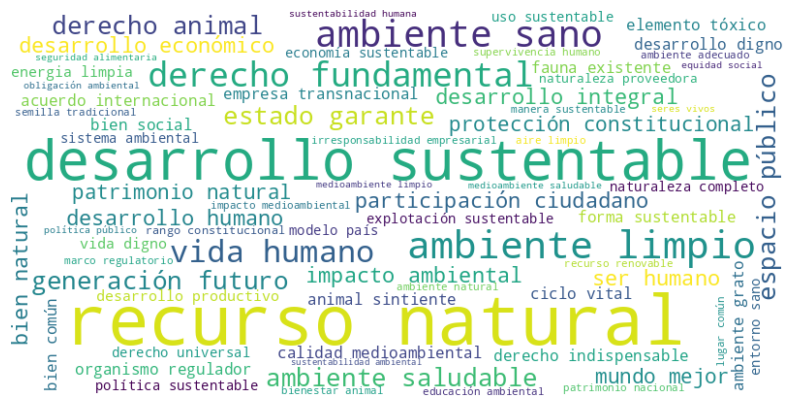

In [41]:
ngram_count = ngram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')

data = dict(zip(ngram_count['ngram'].tolist(), ngram_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=170).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Los bigramas más frecuentes en la nube de palabras son recurso natural, desarrollo sustentable, ambiente limpio, ambiente sano, derecho fundamental, vida humano, estado garante, derecho animal, generación futuro, desarrollo humano, desarrollo económico, bien natural, impacto ambiental, ambiente saludable, espacio público, protección constitucional, ser humano, mundo mejor, patrimonio natural, participación ciudadano y desarrollo integral.

Estos bigramas expresan temas esperables para explicar el 'respeto al medio ambiente", debido a que plantean problemas respecto a la contaminación, destrucción del medio ambiente y su mitigación mediante la aplicación de normas (ambiente limpio, derecho fundamental, impacto ambiental, protección constitucional, estado garante). Como se mencionó en el wordcloud de sustantivos, medio ambiente engloba los bigramas relacionados con la naturaleza.

También plantea que es importante que exista desarrollo económico y que sea compatible con la protección del medio ambiente.

Es interesante la mención del derecho animal, el cual se considera por especialistas que es un derecho que compite con el derecho ambiental dado que buscan propósitos contrapuestos entre sí.

Crear red de bigramas para el concepto "Respeto a la naturaleza/medio ambiente"

In [42]:
ngram_count # dataframe con bigramas y su frecuencia

,ngram,counts
0,recurso natural,32
1,desarrollo sustentable,19
2,ambiente limpio,8
3,ambiente sano,7
4,derecho fundamental,6
5,vida humano,5
6,estado garante,3
7,generación futuro,3
8,derecho animal,3
9,ambiente saludable,3


In [43]:
ngram_count[['token_1', 'token_2']] = ngram_count['ngram'].str.split(' ', n=1, expand=True) # separa los bigramas en tokens

In [44]:
ngram_count['weight'] = ngram_count['counts'] # considera la frecuencia como pesos de la red

In [45]:
ngram_count

,ngram,counts,token_1,token_2,weight
0,recurso natural,32,recurso,natural,32
1,desarrollo sustentable,19,desarrollo,sustentable,19
2,ambiente limpio,8,ambiente,limpio,8
3,ambiente sano,7,ambiente,sano,7
4,derecho fundamental,6,derecho,fundamental,6
5,vida humano,5,vida,humano,5
6,estado garante,3,estado,garante,3
7,generación futuro,3,generación,futuro,3
8,derecho animal,3,derecho,animal,3
9,ambiente saludable,3,ambiente,saludable,3


In [46]:
G = nx.Graph() # crea red vacía

In [47]:
G = nx.from_pandas_edgelist(ngram_count, source='token_1', target='token_2', edge_attr='weight')

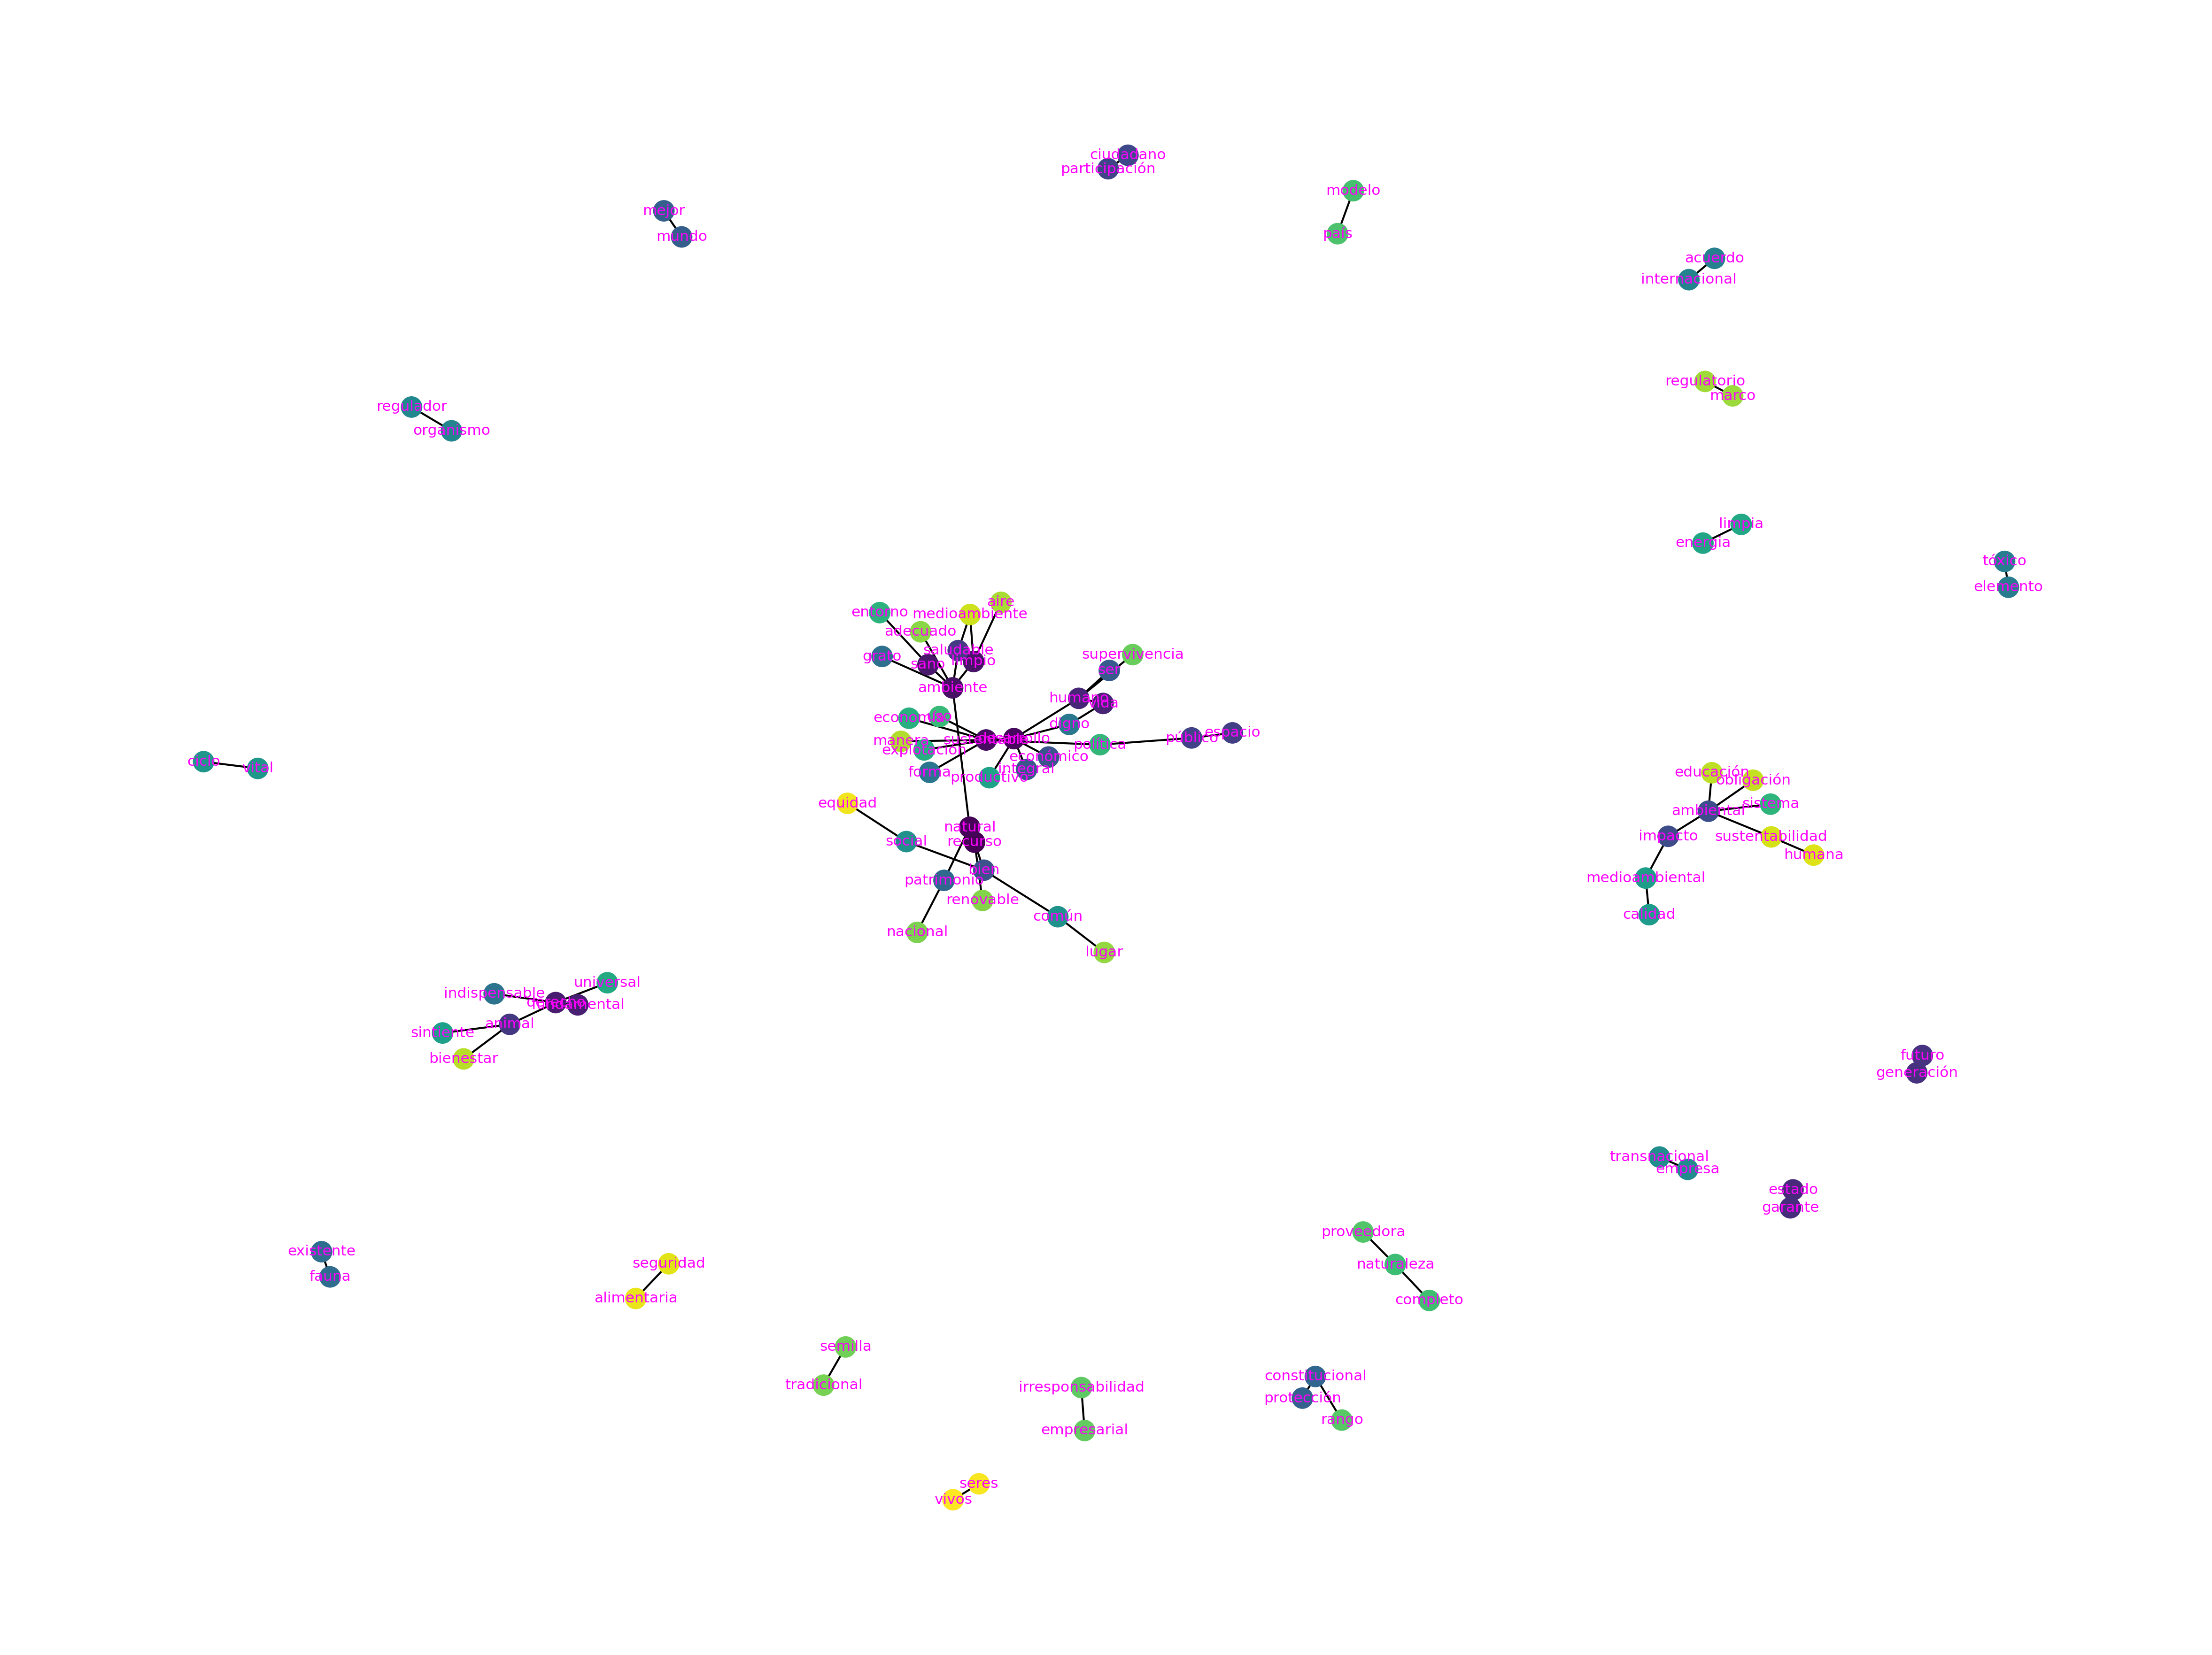

In [48]:
# Grafica red de bigramas
from matplotlib.pyplot import figure

figure(figsize=(20, 15), dpi=300)
fig = plt.plot()

val = []
for i in range(len(G.nodes)):
    val.append(i)

nx.set_node_attributes(G, val, 'val')
nx.draw_spring(G, node_size=100, with_labels=True, node_color=val, font_size=7.5, font_family='sans-serif', font_color='fuchsia')

plt.show()

Se observan hubs de bigramas de distinto tamaño. El hub de mayor tamaño contiene las palabras recurso, medioambiente, desarrollo, política. Desde la palabra ambienta se derivan conceptos tales como educación, impacto, obligación, y sustentabilidad.  

Otro hub más pequeño contiene la palabra animal, considerando derecho, bienestar y sintiente como palabras relacionadas. Además menciona derecho fundamental y universal. El concepto central es el derecho.

Existen otros bigramas que no están conectados a los hubs anteriormente mencionados, tales como marco regulatorio, organismo regulador, semilla tradicional, fauna existente, ciclo vital, acuerdo internacional,  irresponsabilidad empresarial, y seres vivos.

### Descripción del concepto "Respeto a la naturaleza/medioambiente."

Luego de analizar los wordclouds y las frases de los participantes de los cabildos provinciales de 2016, podemos describir al "Respeto a la naturaleza/medio ambiente" como un concepto que busca el equilibro entre el cuidado de la naturaleza y el desarrollo económico del país.

Frases tales como las que mencionaremos a continuación implican que es relevante encontrar un punto medio entre el progreso humano y la protección del medio ambiente:

* "Debe establecerse que el desarrollo humano y económico debe basarse en una explotación sustentable de los recursos naturales, asegurando su existencia y preservación para las futuras generaciones." (Sustentabilidad)

* "El concepto debe estar asociado al desarrollo sustentable ya que se debe resguardar el derecho al desarrollo productivo y oportunidad de empleo. Requiere empatía y compromiso de la sociedad y la creación de leyes."

* "Una fuerte legislación hacia la industria que es principal responsable del impacto medioambiental. Donde también existe un modelo económico que implica la destrucción y la inconsecuencia hacia el medioambiente. No se trata de eliminar el modelo sino que saber usarlo. Así como toda manera de inculcar."

* "Derecho a vivir en un medio ambiente libre de contaminación y que garantice la protección de los bienes naturales."

Los siguientes bigramas concuerdan con esta descripción:

organismo regulador, acuerdo internacional, estado garante, energía limpia, recurso renovable, calidad medioambiental, economía sustentable, participación ciudadano, educación ambiental, marco regulatorio, impacto ambiental.


